In [1]:
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import least_squares, minimize

import archimedes as arc
from archimedes import tree
from archimedes.experimental.sysid import make_pem
from archimedes.experimental.discretize import discretize_rk4

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

In [2]:
# Dynamics function
system = CartPole()

# Discretize the dynamics
# f = discretize_rk4(system.dynamics, dt)

x0 = np.array([0.0, 3.0, 0.0, 0.0])  # Initial state

t0, tf = 0.0, 20.0

u0 = np.array([0.0])
dt = 0.001
ts = np.arange(t0, tf, dt)


def f(t, x):
    return system.dynamics(t, x, u0)


xs_true = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts, rtol=1e-6, atol=1e-8)
# xs = np.zeros((len(ts), 4))
# xs[0] = x0
# for i in range(1, len(ts)):
#     xs[i] = f(ts[i-1], xs[i-1], us[i])

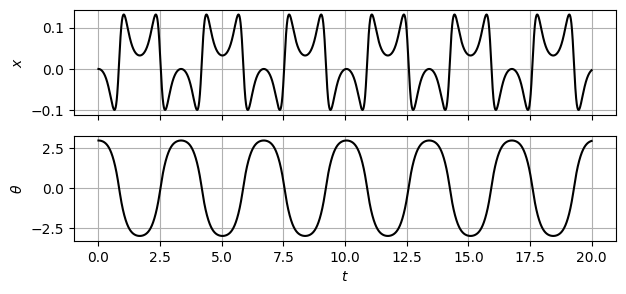

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [4]:
params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

x0_guess = np.array([0.0, 3.0, 0.0, 0.0])

# Optimize the initial condition and parameters
# dvs_guess = x0_guess, params_guess
dvs_guess = params_guess
dvs_guess_flat, unravel = tree.ravel(dvs_guess)

In [5]:
@arc.compile(kind="MX", static_argnames=("fwd",))
def residuals(fwd, dvs_guess_flat):
    xs_pred = fwd(dvs_guess_flat)
    return xs_true - xs_pred

# Shooting

In [6]:
def ode_rhs(t, x, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u0)


@arc.compile
def fwd_shoot(dvs_flat):
    params = unravel(dvs_flat)

    f = arc.compile(ode_rhs)
    xs_pred = arc.odeint(
        f, x0=x0, t_span=(t0, tf), args=(params,), t_eval=ts, rtol=1e-6, atol=1e-8
    )
    return xs_pred


xs_pred = fwd_shoot(dvs_guess_flat)

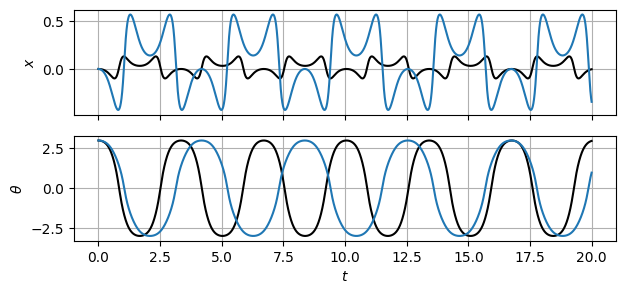

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [8]:
residuals(fwd_shoot, dvs_guess_flat)

array([[ 0.00000000e+00,  4.68182375e-07,  1.87100578e-06, ...,
         3.37775120e-01,  3.39528883e-01,  3.41261695e-01],
       [ 0.00000000e+00, -4.35924277e-07, -1.73159744e-06, ...,
         2.00509275e+00,  1.99953064e+00,  1.99398392e+00],
       [ 0.00000000e+00,  9.35056742e-04,  1.87012773e-03, ...,
         1.76428004e+00,  1.74326628e+00,  1.72237784e+00],
       [ 0.00000000e+00, -8.63328814e-04, -1.72669794e-03, ...,
        -5.56984806e+00, -5.55438907e+00, -5.53905752e+00]],
      shape=(4, 20000))

In [9]:
@arc.compile
def obj_shoot(dvs_guess_flat):
    r = residuals(fwd_shoot, dvs_guess_flat)
    r_norm = np.sum(r**2, axis=0)
    xs_norm = np.sum(xs_true**2, axis=0)
    return np.sum(r_norm / xs_norm)


obj_shoot(dvs_guess_flat)

array(43683.9504611)

In [10]:
# def callback(intermediate_result):
#     print(intermediate_result.fun, intermediate_result.x)

# bounds = [(0.0, np.inf) for _ in range(len(dvs_guess_flat))]

# minimize(
#     obj_shoot,
#     dvs_guess_flat,
#     # method="L-BFGS-B",
#     method="trust-constr",
#     jac=arc.jac(obj_shoot),
#     hess=arc.hess(obj_shoot),
#     options={"disp": True},
#     bounds=bounds,
#     callback=callback,
# )

In [11]:
# arc.minimize(obj_shoot, dvs_guess_flat)

# Set up PEM

In [12]:
# Discretize with RK4
dyn = discretize_rk4(ode_rhs, dt)


def obs(t, x, dvs_flat):
    return x

In [13]:
nx, ny = 4, 4
Q = np.eye(nx)
R = 1e4 * np.eye(ny)

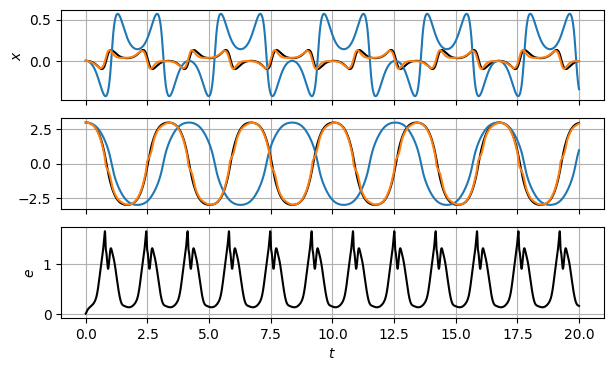

In [14]:
kf_fwd = make_pem(
    dyn,
    obs,
    ts,
    xs_true,
    Q=Q,
    R=R,
)

args = (params_guess,)
x_hat, e, _, _, _ = kf_fwd(x0, args)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, x_hat[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, x_hat[1])
ax[1].grid()
ax[2].set_ylabel(r"$\theta$")
ax[2].plot(ts, np.linalg.norm(e, axis=0), c="k")
ax[2].grid()
ax[2].set_ylabel(r"$e$")
ax[-1].set_xlabel(r"$t$")

plt.show()

# NLP solver

In [15]:
@arc.compile
def obj_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, _, _, _ = kf_fwd(x0, (params,))
    return np.sum(e.flatten() ** 2) / len(e.flatten())


obj_pem(dvs_guess_flat)

array(0.15551019)

In [16]:
arc.jac(obj_pem)(dvs_guess_flat)

array([ 0.30857759, -0.27066048,  0.27066048])

In [17]:
@arc.compile
def obj_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, J, _, _ = kf_fwd(x0, (params,))
    return J

obj_pem(dvs_guess_flat)

array(0.62204076)

In [18]:
arc.jac(obj_pem)(dvs_guess_flat)

array([ 1.23431038, -1.08264192,  1.08264192])

In [19]:
def callback(intermediate_result):
    print(intermediate_result.fun, intermediate_result.x)


sol = minimize(
    obj_pem,
    dvs_guess_flat,
    method="BFGS",
    # method="trust-exact",
    jac=arc.jac(obj_pem),
    # hess=arc.hess(obj_pem),
    options={"disp": True},
    callback=callback,
)
dvs_opt_flat = sol.x

0.1289745453428519 [ 0.36610605  1.05600291 -0.05600291]
0.1063959489943291 [0.65995751 1.24331691 0.14395541]
0.06872966322360646 [0.64227425 1.25905651 0.22551651]
0.010529733286261693 [0.54339334 1.22788022 0.29132706]
0.001282918733542946 [0.50082636 1.2096146  0.3133557 ]
0.00031639477953430945 [0.49422707 1.20129872 0.3363541 ]
1.71239082235402e-05 [0.49813593 1.19733746 0.35458522]
5.935468172160387e-08 [0.49994868 1.19663359 0.35901644]
4.903208530811315e-08 [0.49999836 1.19665794 0.35900181]
4.898945309314342e-08 [0.50000072 1.19666044 0.35899697]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


In [20]:
# Simulate forward with optimal parameters
xs_opt = fwd_shoot(dvs_opt_flat)

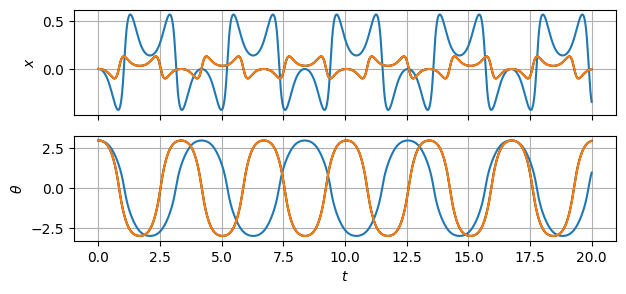

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

# Least-squares optimization

In [22]:
@arc.compile
def res_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, _, _, _ = kf_fwd(x0, (params,))
    return e.flatten()


res_pem(dvs_guess_flat)

array([ 6.71886914e-07,  2.48183225e-06,  5.22568926e-06, ...,
       -7.82080595e-02, -7.77397816e-02, -7.72792275e-02], shape=(80000,))

In [23]:
bounds = [(0.0, np.inf) for _ in dvs_guess_flat]
sol = least_squares(
    res_pem,
    dvs_guess_flat,
    jac=arc.jac(res_pem),
    # bounds=bounds,
    verbose=2,
    loss="linear",
    x_scale="jac",
)

dvs_opt_flat = sol.x
unravel(dvs_opt_flat)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2204e+03                                    1.23e+04    
       1              3         1.6788e+03      4.54e+03       3.08e-01       8.22e+03    
       2              4         2.9455e+02      1.38e+03       5.49e-01       4.80e+03    
       3              6         7.3226e+00      2.87e+02       2.55e-01       4.43e+02    
       4              7         9.5061e-01      6.37e+00       5.58e-01       1.09e+02    
       5              9         4.2052e-02      9.09e-01       2.80e-01       2.74e+01    
       6             10         2.3544e-02      1.85e-02       5.58e-01       3.58e+01    
       7             11         4.6851e-03      1.89e-02       5.58e-01       8.74e+00    
       8             12         1.3791e-03      3.31e-03       1.12e+00       2.58e+00    
       9             13         6.9422e-04      6.85e-04       2.23e+00       1.24e+00    

{'L': array(0.5000007), 'm1': array(3.92551551), 'm2': array(1.17765064)}

In [24]:
# Simulate forward with optimal parameters
xs_opt = fwd_shoot(dvs_opt_flat)

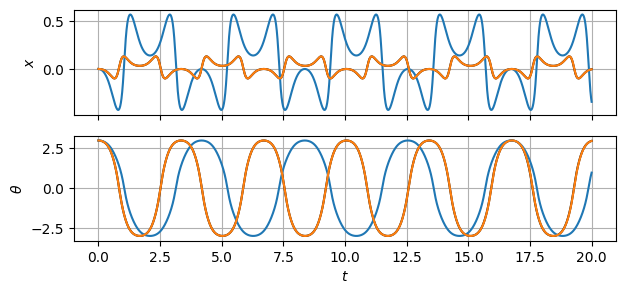

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [26]:
psi(dvs_guess_flat).shape

NameError: name 'psi' is not defined

In [ ]:
psi(dvs_guess_flat).shape

(80000, 3)

# Custom Gauss-Newton

In [ ]:
@arc.compile
def obj_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, V, J, H = kf_fwd(x0, (params,))
    return V, J, H


V, J, H = obj_pem(dvs_guess_flat)

In [ ]:
V, J, H = obj_pem(dvs_guess_flat)

In [ ]:
from archimedes.experimental.sysid.pem import pem_lm
p_opt = pem_lm(dvs_guess_flat, obj_pem)

Iteration    Total nfev     Cost       Optimality
----------   ----------  ----------    ----------
Matrix is singular, using fallback
   1              2     2.5088e-01            0.0000
   2             10     1.3279e-01            0.0000
